<a href="https://colab.research.google.com/github/NaamaZecharia/TFlower/blob/master/TFlower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
assert tf.__version__.startswith('2')

import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#Download the flowers dataset

In [ ]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"


zip_file = tf.keras.utils.get_file(origin=_URL, 
                                   fname="flower_photos.tgz", 
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

228818944/228813984 [==============================] - 2s 0us/step


In [ ]:
# Use ImageDataGenerator to rescale the images.

# Create the train generator and specify where the train dataset directory, image size, batch size.

# Create the validation generator with similar approach as the train generator with the flow_from_directory() method.

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [ ]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((64, 224, 224, 3), (64, 5))

In [ ]:
# Save the labels in a file 

In [ ]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


In [ ]:
!cat labels.txt

daisy
dandelion
roses
sunflowers
tulips

In [ ]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2 
#include_top = refers to including or not the densely-connected classifier on top of the network
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False,  weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


**Feature extraction**
freezing the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

In [ ]:
base_model.trainable = False

 Add a classification head

In [ ]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(5, activation='softmax')
])

**Compile the model**
compile the model before training it. Since there are multiple classes, use a categorical cross-entropy loss.

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 2,626,821
Trainable params: 368,837
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


# **Train the model**

In [ ]:
epochs = 10

history = model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=epochs, validation_data=val_generator, validation_steps=len(val_generator))

Epoch 1/10
46/46 [==============================] - 129s 3s/step - loss: 0.7553 - accuracy: 0.7383 - val_loss: 0.4827 - val_accuracy: 0.8304
Epoch 2/10
46/46 [==============================] - 128s 3s/step - loss: 0.3200 - accuracy: 0.8867 - val_loss: 0.4368 - val_accuracy: 0.8345
Epoch 3/10
46/46 [==============================] - 132s 3s/step - loss: 0.2104 - accuracy: 0.9299 - val_loss: 0.4088 - val_accuracy: 0.8700
Epoch 4/10
46/46 [==============================] - 129s 3s/step - loss: 0.1291 - accuracy: 0.9558 - val_loss: 0.4272 - val_accuracy: 0.8536
Epoch 5/10
46/46 [==============================] - 130s 3s/step - loss: 0.0796 - accuracy: 0.9762 - val_loss: 0.4586 - val_accuracy: 0.8591
Epoch 6/10
46/46 [==============================] - 127s 3s/step - loss: 0.0523 - accuracy: 0.9857 - val_loss: 0.4508 - val_accuracy: 0.8632
Epoch 7/10
46/46 [==============================] - 131s 3s/step - loss: 0.0296 - accuracy: 0.9963 - val_loss: 0.4596 - val_accuracy: 0.8728
Epoch 8/10
46

# Learning curves

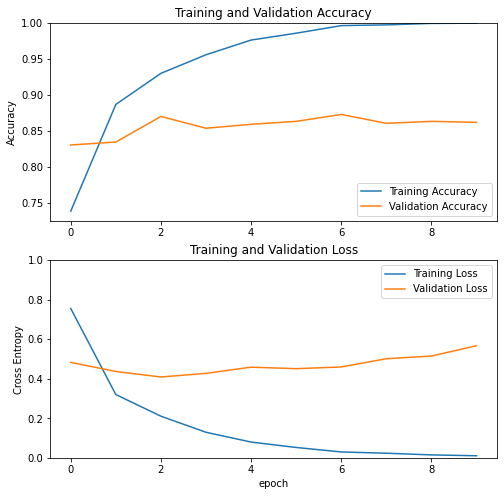

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine tuning
We were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier we added. The training process will force the weights to be tuned from generic features maps to features associated specifically to our dataset.



# Un-freeze the top layers of the model
unfreeze the `base_model` and set the bottom layers be un-trainable. Then, recompile the model (necessary for these changes to take effect), and resume training.

In [ ]:
base_model.trainable = True

In [ ]:
# see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


# Compile the model
Compile the model using a much lower training rate.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(1e-5), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 2,626,821
Trainable params: 2,231,429
Non-trainable params: 395,392
_________________________________________________________________


In [ ]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 60


In [ ]:
# Continue Train the model
history_fine = model.fit(train_generator, 
                         steps_per_epoch=len(train_generator), 
                         epochs=5, 
                         validation_data=val_generator, 
                         validation_steps=len(val_generator))

Epoch 1/5
46/46 [==============================] - 235s 5s/step - loss: 0.3972 - accuracy: 0.8687 - val_loss: 0.5834 - val_accuracy: 0.8646
Epoch 2/5
46/46 [==============================] - 229s 5s/step - loss: 0.2027 - accuracy: 0.9241 - val_loss: 0.5919 - val_accuracy: 0.8673
Epoch 3/5
46/46 [==============================] - 218s 5s/step - loss: 0.1384 - accuracy: 0.9520 - val_loss: 0.5906 - val_accuracy: 0.8673
Epoch 4/5
46/46 [==============================] - 223s 5s/step - loss: 0.1130 - accuracy: 0.9605 - val_loss: 0.5778 - val_accuracy: 0.8714
Epoch 5/5
46/46 [==============================] - 219s 5s/step - loss: 0.0770 - accuracy: 0.9765 - val_loss: 0.5701 - val_accuracy: 0.8728


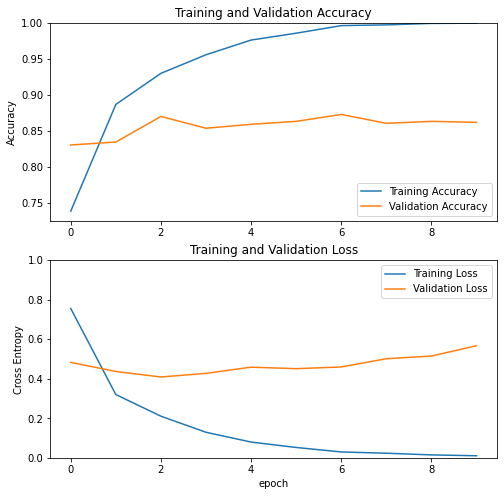

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Convert to TFLite
save the model using tf.saved_model.save and then convert the saved model to a tf lite compatible format

In [ ]:
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: save/fine_tuning/assets


In [ ]:
#Download the converted model and labels
from google.colab import files

files.download('model.tflite')
files.download('labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

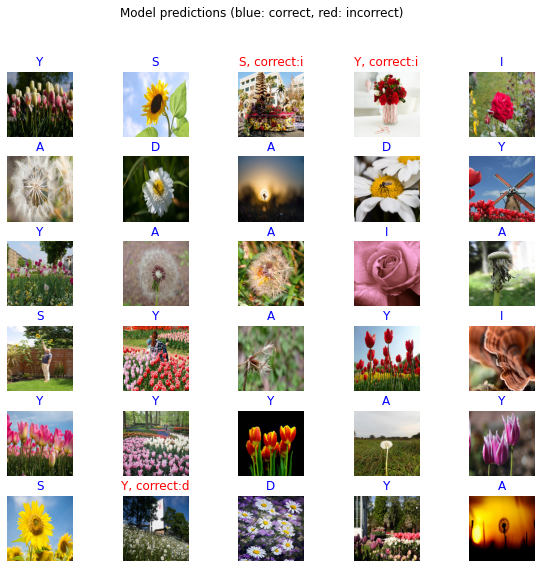

In [ ]:
# get a random batch of images
image_batch, label_batch = next(iter(val_generator))
# turn the original labels into human-readable text
label_batch = [labels[np.argmax(label_batch[i])] for i in range(BATCH_SIZE)]
# predict the images on the model
predicted_class_names = model.predict(image_batch)
predicted_ids = [np.argmax(predicted_class_names[i]) for i in range(BATCH_SIZE)]
# turn the predicted vectors to human readable labels
predicted_class_names = np.array([labels[id] for id in predicted_ids])
# some nice plotting
plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    if predicted_class_names[n] == label_batch[n]:
        color = "blue"
        title = predicted_class_names[n].title()
    else:
        color = "red"
        title = f"{predicted_class_names[n].title()}, correct:{label_batch[n]}"
    plt.title(title, color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")
plt.show()